# Exposure to change in heatwave occurrance


> Now using the new heatwave definitions that depend on both the tmin and tmax percentiles

---

> Using upscaled population data for pre-2000, this is an approximation! Needs to be shown as such on the graphs 

---

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd

import xarray as xr
import matplotlib.pyplot as plt

from cartopy import crs as ccrs
from scipy import stats

from config import DATA_SRC, POP_DATA_SRC, WEATHER_SRC

In [2]:
# Figure settings
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.figsize'] = (5,2.5)
plt.rcParams['figure.titlesize'] = 'medium'
plt.rcParams['axes.titlesize'] = 'medium'
plt.rcParams['savefig.bbox'] = 'tight'

In [3]:
MAP_PROJECTION = ccrs.EckertIII()

In [4]:
MAX_YEAR = 2020

REFERENCE_YEAR_START = 1986
REFERENCE_YEAR_END = 2005

RESULTS_FOLDER = Path('../results/heatwaves/').absolute()

INTERMEDIATE_RESULTS_FOLDER = DATA_SRC / 'lancet'/ 'heatwaves'/ 'results_2021'

GPW_FILE = DATA_SRC/ 'lancet/population/UN WPP-Adjusted Population Count v4.11 2000-2020 15min era compat.nc'
# POPULATION_VAR = 'UN WPP-Adjusted Population Count, v4.11 (2000-2020)'

# DEMOGRAPHICS_TOTALS_FILE = POP_DATA_SRC / 'demographics_2000_2020_15_min_era_compat.nc'
DEMOGRAPHICS_TOTALS_FILE = POP_DATA_SRC / 'demographics_hybrid_1950_2020_15_min_era_compat.nc'

In [ ]:
MIN_YEAR = 1980



# Load Data

## Load GPW data

In [5]:
gpw_dat = xr.open_dataset(GPW_FILE)

## Load country data

In [6]:
COUNTRIES_RASTER = gpw_dat['National Identifier Grid, v4.11 (2010): National Identifier Grid'].load()

In [7]:
land_mask  = (COUNTRIES_RASTER < 2000)

## Load population and demographic data

In [8]:
# population = gpw_dat[POPULATION_VAR]

In [9]:
demographics_totals = xr.open_dataarray(DEMOGRAPHICS_TOTALS_FILE)
population_over_65 = demographics_totals.sel(age_band_lower_bound=65, drop=True).load()

## Load heatwave lengths and counts data

> TODO would like to split this up into yearly files so I only need to re-do one year at a time...

In [10]:
heatwave_metrics_files = [f'heatwaves_counts_multi_threshold_1980-{MAX_YEAR}.nc', 
                          f'heatwaves_days_multi_threshold_1980-{MAX_YEAR}.nc', 
                          f'heatwave_mean_length_multi_threshold_1980-{MAX_YEAR}.nc'
                         ]

heatwave_metrics_files = [
    INTERMEDIATE_RESULTS_FOLDER / f 
    for f in heatwave_metrics_files
]
heatwave_metrics = xr.open_mfdataset(heatwave_metrics_files, combine='by_coords')

### Calculate the difference from the mean number of days and number of events

> NOTE: we do a sort of double-difference in this case, since we first define heatwaves based on a historical distribution (99th percentile) then we again calculate the change. Question is open as to whether it's also critical to use the same period for calculating the percentile and calculating the reference period. Also a question whether we should compare the change in exposures rather than the change in heatwaves. The problem (or maybe it's a benefit??) is that you also mix in changes in total population and demographics


In [11]:
heatwaves_metrics_reference = heatwave_metrics.sel(year=slice(REFERENCE_YEAR_START, REFERENCE_YEAR_END)).mean(dim='year')
heatwave_metrics_delta = heatwave_metrics - heatwaves_metrics_reference

## Calculate some utility data

In [12]:
# Get the grid weighting factor from the latitude
cos_lat = xr.ufuncs.cos(xr.ufuncs.radians(heatwave_metrics.latitude))
# Get the total population for normalising
total_pop_over_65 = population_over_65.sum(dim=['latitude', 'longitude'], skipna=True)

# Map plots of heatwaves

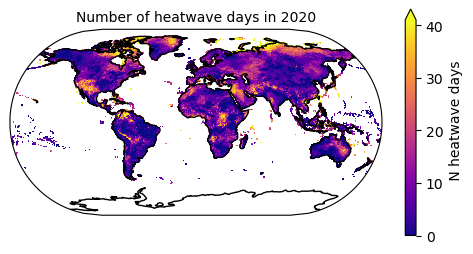

In [14]:
data = heatwave_metrics.where(land_mask).heatwaves_days.sel(year=MAX_YEAR)

f, ax = plt.subplots(figsize=(6,3), 
                     subplot_kw=dict(projection=MAP_PROJECTION))

p = data.plot.pcolormesh(
    transform=ccrs.PlateCarree(),
    cmap='plasma',
    cbar_kwargs={
                 'label':' N heatwave days'},
    robust=True
)

ax.set(title=f'Number of heatwave days in {MAX_YEAR}')

ax.coastlines()

f.savefig(RESULTS_FOLDER / f'map_heatwave_days_{MAX_YEAR}.png')

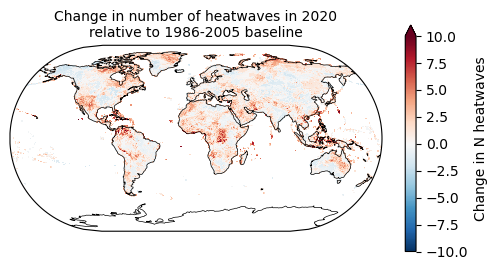

In [17]:
data = heatwave_metrics_delta.where(land_mask).heatwaves_counts.sel(year=MAX_YEAR)

f, ax = plt.subplots(figsize=(6,3), subplot_kw=dict(projection=MAP_PROJECTION))

p = data.plot.pcolormesh(
    transform=ccrs.PlateCarree(),
    cbar_kwargs={
                 'label':'Change in N heatwaves'},
    center=0,
    vmax=10,  
    cmap='RdBu_r', 
)
ax.set(title=f'Change in number of heatwaves in {MAX_YEAR}\nrelative to 1986-2005 baseline')

ax.coastlines(linewidth=0.5)

# f.savefig(RESULTS_FOLDER / f'map_change_heatwave_days_{MAX_YEAR}.png')

In [16]:
data = heatwave_metrics_delta.where(land_mask).heatwaves_days.sel(year=MAX_YEAR)

f, ax = plt.subplots(figsize=(6,3), subplot_kw=dict(projection=MAP_PROJECTION))

p = data.plot.pcolormesh(
    transform=ccrs.PlateCarree(),
    cbar_kwargs={
                 'label':'Change in N heatwave days'},
    center=0,
    vmax=50,  
    cmap='RdBu_r', 
)
ax.set(title=f'Change in number of heatwave days in {MAX_YEAR}\nrelative to 1986-2005 baseline')

ax.coastlines(linewidth=0.5)

f.savefig(RESULTS_FOLDER / f'map_change_heatwave_days_{MAX_YEAR}.png')

# Calculate total exposures and save for all metrics

Because the calculation is the same for all metrics, we can calculated it once on the dataset and save

In [13]:
exposures = heatwave_metrics_delta * population_over_65

In [27]:
exposures.to_netcdf(INTERMEDIATE_RESULTS_FOLDER / f'heatwave_exposure_change_multi_threshold_{MIN_YEAR}-{MAX_YEAR}.nc')

/home/jonathanchambers/Scratch/.conda/envs/scienceforge/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [21]:
exposures = xr.open_dataset(INTERMEDIATE_RESULTS_FOLDER / f'heatwave_exposure_change_multi_threshold_2000-{MAX_YEAR}.nc')

## Total Exposure to change in  to heatwaves

Calculate exposure changes in terms of difference aspects of heatwaves - frequency, length, load. 

> **NOTE**: Keep the of number of individual events (rather than number of days) for historical reasons, but no longer focus on that because number of heatwave days is just generally a better measure than individual instances.


In [16]:
total_exposures = exposures.sum(dim=['latitude', 'longitude']).to_dataframe()

/home/jonathanchambers/Scratch/.conda/envs/scienceforge/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [17]:
total_exposures.to_excel(RESULTS_FOLDER / 'heatwave_exposure_indicator_totals.xlsx')

# Calculate global mean and exposure weighted values for all metrics

In [1]:
global_mean = (heatwave_metrics_delta * cos_lat).mean(dim=['latitude', 'longitude'])
weighted_mean = (heatwave_metrics_delta * population_over_65 / total_pop_over_65).sum(dim=['latitude', 'longitude'], skipna=True)

NameError: name 'heatwave_metrics_delta' is not defined

In [2]:
global_mean = global_mean.to_dataframe()
weighted_mean = weighted_mean.to_dataframe()

NameError: name 'global_mean' is not defined

In [20]:
global_mean.to_excel(RESULTS_FOLDER / 'metrics_global_mean.xlsx')
weighted_mean.to_excel(RESULTS_FOLDER / 'metrics_weighted_mean.xlsx')

## Plot Global mean and exposure weighted means for heatwave metrics

In [21]:
global_mean = pd.read_excel(RESULTS_FOLDER / 'metrics_global_mean.xlsx').set_index('year')
weighted_mean = pd.read_excel(RESULTS_FOLDER / 'metrics_weighted_mean.xlsx').set_index('year')

In [22]:
f, axs = plt.subplots(2,2, sharex=True, 
                      figsize=(6,4),
                      constrained_layout=True
                     )

metrics  = ['heatwaves_counts', 'heatwaves_days','heatwave_mean_length']
y_labels = ['[˚C-days]', '[days]', '[days]', '[˚C]']
titles   = ['Change in heatwave\n number', 'Change in number\n of heatwave days',
          'Change in heatwave\n mean length',]

for metric, ylab, title, ax in zip(metrics, y_labels, titles, axs.flat):
    global_mean[metric].plot(style='--', color='C0',label='Global mean', ax=ax)
    weighted_mean[metric].plot(color='C1',label='Exposure weighted mean', ax=ax)
    ax.set(
        xlabel='Year',
        ylabel=ylab,
        title=title
    )

axs[1,0].legend(loc='lower center', bbox_to_anchor=(0.5, -1))

f.savefig(RESULTS_FOLDER / f'heatwaves_metrics_weighted_1980-{MAX_YEAR}.png', bbox_inches='tight')


In [28]:
# (total_exposures.rolling(10, center=True).mean().dropna()).to_excel(RESULTS_FOLDER / 'heatwave_exposure_indicator_totals_10yr_mean.xlsx')

## Reload saved numbers

In [26]:
total_exposures = pd.read_excel(RESULTS_FOLDER / 'heatwave_exposure_indicator_totals.xlsx', index_col='year')

## Count of separate heatwave events (depreciated)

Calculate the change in number of people exposed to heatwaves over time. One exposure event = 1 person * 1 heatwave

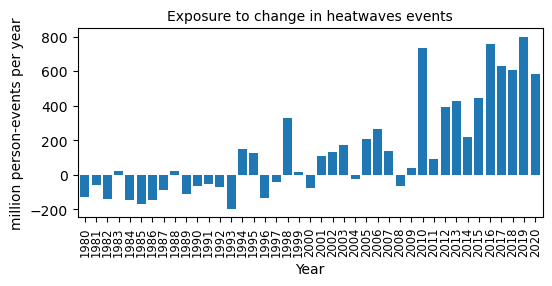

In [23]:
ax = (total_exposures.heatwaves_counts / 1e6).plot.bar(label='Change relative to recent past average', width=0.8)
f = ax.figure
f.set_size_inches((6, 2.5))

ax.set(
    xlabel='Year',
    ylabel='million person-events per year',
    title='Exposure to change in heatwaves events'
)

ax.tick_params(axis='x', labelsize='small')

f.savefig(RESULTS_FOLDER / f'heatwaves_exposure_1980-{MAX_YEAR}.png')
f.savefig(RESULTS_FOLDER / f'heatwaves_exposure_1980-{MAX_YEAR}.pdf')


## Exposure to change in number of days (HWMI analogue)

This supercedes the number of exposure events, and is closer to the HWMI method of calculating heatwaves

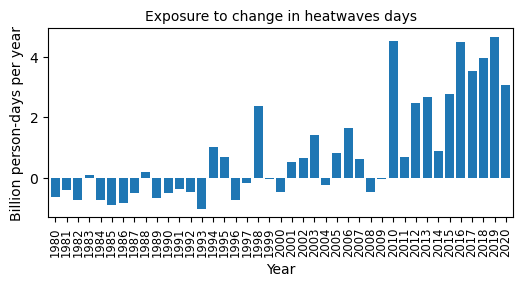

In [24]:
ax = (total_exposures.heatwaves_days / 1e9).plot.bar(label='Change relative to recent past average', width=0.8)
f = ax.figure
f.set_size_inches((6, 2.5))

ax.set(
    xlabel='Year',
    ylabel='Billion person-days per year',
    title='Exposure to change in heatwaves days'
)

ax.xaxis.set_tick_params(labelsize='small')

f.savefig(RESULTS_FOLDER / f'heatwaves_exposure_days_1980-{MAX_YEAR}.png')
f.savefig(RESULTS_FOLDER / f'heatwaves_exposure_days_1980-{MAX_YEAR}.pdf')


## Calculate the average exposure

In [25]:
heatwave_events_historical = (heatwave_metrics * 
                              population_over_65
                             ).sel(year=slice(REFERENCE_YEAR_START, REFERENCE_YEAR_END)).mean(dim='year')

heatwave_events_historical = heatwave_events_historical.sum(dim=['latitude', 'longitude']).compute()

/home/jonathanchambers/Scratch/.conda/envs/scienceforge/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [26]:
heatwave_events_historical.heatwaves_counts / 1e6

<xarray.DataArray 'heatwaves_counts' ()>
array(449.690336)